In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time
from copy import deepcopy
import itertools
from IPython.display import clear_output

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as Tdata
import torch.nn.functional as F
import torch.distributions as TD
from torchvision import transforms
import torchvision.datasets as TVdatasets
from torchvision.utils import save_image, make_grid

import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../../homeworks') # to grab dgm_utils from ../../homeworks directory
from tqdm import tqdm

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 2
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# dgm_utils
from dgm_utils import train_model, show_samples, visualize_images
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data

def reset_seed():
    OUTPUT_SEED = 0xBADBEEF
    torch.manual_seed(OUTPUT_SEED)
    np.random.seed(OUTPUT_SEED)

reset_seed()

# <center>Deep Generative Models</center>
## <center>Seminar 11</center>

<center><img src="pics/mipt_logo.png" width=600 /></center>
<center>28.03.2023</center>


## Plan

1. StyleGAN. End discussion and evaluation
     
2. Unpaired image-to-image translation

    - CycleGAN details and coding for colored MNIST -> USPS

<!-- 3. Beyond GANs: Neural Optimal Transport 

    - Theory and coding for 2D and coding for colored MNIST -> USPS -->

## StyleGAN. End discussion and evaluation

## Unpaired image-to-image translation problem

We have two domains of data:
* Source domain $X$, data distribution is $\mathbb{P}$
* Target domain $Y$, data distribution is $\mathbb{Q}$

<center><img src="pics/paired_unpaired_i2i.png" width=600 /></center>

**Unpaired I2I examples**:

<center><img src="pics/unpaired_i2i_examples.png" width=1000 /></center>

**Question**: Why can't we just solve the *unpaired image-to-image problem* via GANs, treating the latent distribution of GAN generator as $\mathbb{P}$ (source domain $X$), and adjusting the generated distribution of GAN generator to be $\mathbb{Q}$ (target domain $Y$)?

### CycleGAN

link to the paper: [Zhu et. al.](https://arxiv.org/pdf/1703.10593.pdf).

project page: [link](https://junyanz.github.io/CycleGAN/)

<center><img src="pics/cyclegan_scheme.png" width=1000 /></center>

* Seminal work, a lot of GAN-based Unpaired I2I approaches are based on CycleGAN. ($\sim$ 16K citations)

* Authors propose to utilize two generators:
$$G_{XY}: X \rightarrow Y \, , \, \text{transforms source domain to target domain}\\
G_{YX}: Y \rightarrow X \, , \, \text{transforms target domain to source domain},$$
    and discriminators $D_Y$ and $D_X$, which imposes the target distribution $\mathbb{Q}$ and source distribution $\mathbb{P}$ constraings corresponingly.
    
* **Cycle Consistency loss**:

<center><img src="pics/cycle_consistency_loss.png" width=800 /></center>

* Optional **Identity** loss:

    <center><img src="pics/cyclegan_id_loss.png" width=670 /></center>

    Citation from the article:
> \[Identity loss\] regularize the generator to be near an identity mapping when real samples of the target domain are provided as the input to the generator.

* Final loss (to be **minimized by $G_{XY}, G_{YX}$** and **maximized/minimized** (depends on actual $\mathcal{L}_{\text{GAN}}$) by **$D_Y, D_X$**:
$$\mathcal{L}(G_{XY}, G_{YX}, D_{Y}, D_{X}) = \mathcal{L}_{\text{GAN}}(G_{XY}, D_{Y}) + \mathcal{L}_{\text{GAN}}(G_{YX}, D_{X}) + \lambda_{\text{cyc}}\mathcal{L}_{\text{cyc}}(G_{XY}, G_{YX}) + \lambda_{\text{id}} \mathcal{L}_{\text{id}}(G_{XY}, G_{YX})$$
    

<!-- **Question.** What is the final objective? -->

<!-- $$
G^*_{XY}, G_{YX}^* = \arg\min\limits_{G_{XY}, G_{YX}} \max\limits_{D_X, D_Y} \mathcal{L}(G_{XY}, G_{YX}, D_{Y}, D_{X})
$$ -->

### CycleGAN practice

**Disclaimer**: code for dataset loading and networks is taken from the [NOT_github](https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/seminars/NOT_seminar_strong_solutions.ipynb). The implementation of `CycleGAN` is based on [CycleGAN_github](https://github.com/eriklindernoren/PyTorch-GAN/tree/master/implementations/cyclegan)

### Datasets

We consider $16\times 16$ colorized **MNIST** & **USPS** digit datasets and learn a map between them.

In [3]:
BATCH_SIZE = 64

def random_color(im):
    hue = 360*np.random.rand()
    d = (im *(hue%60)/60)
    im_min, im_inc, im_dec = torch.zeros_like(im), d, im - d
    c_im = torch.zeros((3, im.shape[1], im.shape[2]))
    H = round(hue/60) % 6    
    cmap = [[0, 3, 2], [2, 0, 3], [1, 0, 3], [1, 2, 0], [3, 1, 0], [0, 1, 2]]
    return torch.cat((im, im_min, im_dec, im_inc), dim=0)[cmap[H]]

TRANSFORM = transforms.Compose([
    transforms.Resize(16),
    transforms.ToTensor(),
    random_color,
    transforms.Normalize([0.5],[0.5])
])

# Load train datasets
mnist_train = TVdatasets.MNIST(root='./data', train=True, download=True, transform=TRANSFORM)
usps_train = TVdatasets.USPS(root='./data', train=True, download=True, transform=TRANSFORM)

mnist_loader = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
usps_loader = torch.utils.data.DataLoader(usps_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Load test datasets
mnist_test = TVdatasets.MNIST(root='./data', train=False, download=True, transform=TRANSFORM)
usps_test = TVdatasets.USPS(root='./data', train=False, download=True, transform=TRANSFORM)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE)
usps_test_loader = torch.utils.data.DataLoader(usps_test, batch_size=BATCH_SIZE)

# We use only a few samples from them for the qualitative analysis
X_test_fixed = next(iter(mnist_test_loader))[0]
Y_test_fixed = next(iter(usps_test_loader))[0]

del mnist_test_loader, usps_test_loader, mnist_test, usps_test

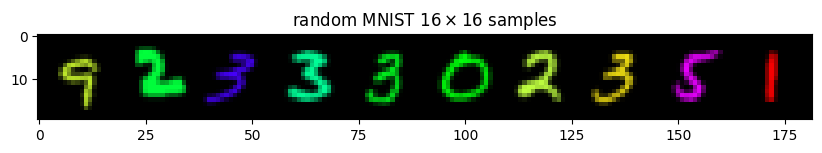

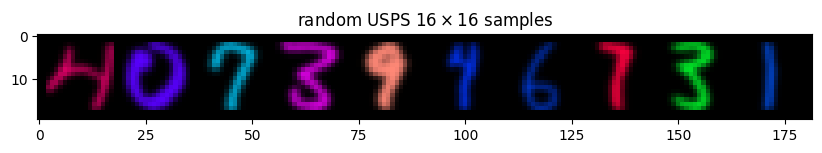

In [4]:
def draw_grid(grid, figsize=(10, 10), title=None):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.asarray(grid.permute(1, 2, 0).cpu()))

draw_grid(
    make_grid(next(iter(mnist_loader))[0][:10], nrow=10, normalize=True), 
    title=r'random MNIST $16\times 16$ samples')
draw_grid(
    make_grid(next(iter(usps_loader))[0][:10], nrow=10, normalize=True), 
    title=r'random USPS $16\times 16$ samples')

Infinite samplers from the **MNIST** and **USPS**:

In [5]:
iter_mnist, iter_usps = iter(mnist_loader), iter(usps_loader)

def sample_mnist():
    global iter_mnist, mnist_loader
    try:
        return next(iter_mnist)[0]
    except StopIteration:
        iter_mnist = iter(mnist_loader)
        return next(iter_mnist)[0]

def sample_usps():
    global iter_usps, usps_loader
    try:
        return next(iter_usps)[0]
    except StopIteration:
        iter_usps = iter(usps_loader)
        return next(iter_usps)[0]

### Models

**Generators**. Original architecture utilize ResNet-like architecture. We will use something more simple.

In [6]:
# Generator from domain X to domain Y

G_XY = nn.Sequential(
    nn.Conv2d(3, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 128, kernel_size=5, padding=2),
    nn.ReLU(True),
    nn.Conv2d(128, 3, kernel_size=5, padding=2),
)

# Generator from domain Y to domain X

G_YX = deepcopy(G_XY)

G_XY = G_XY.to(DEVICE)
G_YX = G_YX.to(DEVICE)

# # Discriminator for domain X

# D_X = nn.Sequential(
#     nn.Conv2d(3, 128, kernel_size=5, padding=2),
#     nn.ReLU(True),
#     nn.AvgPool2d(2), #  128 x 8 x 8
#     nn.Conv2d(128, 256, kernel_size=5, padding=2),
#     nn.ReLU(True),
#     nn.AvgPool2d(2), #  256 x 4 x 4
#     nn.Conv2d(256, 512, kernel_size=5, padding=2),
#     nn.ReLU(True),
#     nn.AvgPool2d(2), #  512 x 2 x 2
#     nn.Conv2d(512, 512, kernel_size=3, padding=1),
#     nn.ReLU(True),
#     nn.AvgPool2d(2), #  512 x 1 x 1
#     nn.Conv2d(512, 1, kernel_size=1, padding=0),
#     nn.Flatten(1),
# )

# Discriminator for domain Y

# D_Y = deepcopy(D_X)

# D_X = D_X.to(DEVICE)
# D_Y = D_Y.to(DEVICE)


# weight initialization

# def weights_init_normal(m):
#     classname = m.__class__.__name__
#     if classname.find("Conv") != -1:
#         torch.nn.init.normal_(m.weight.data, 0.0, 0.025)
#         if hasattr(m, "bias") and m.bias is not None:
#             torch.nn.init.constant_(m.bias.data, 0.0)

# D_Y.apply(weights_init_normal)
# D_X.apply(weights_init_normal)
# G_XY.apply(weights_init_normal)
# G_YX.apply(weights_init_normal)



print('G_XY (G_YX) parameters:', np.sum([np.prod(p.shape) for p in G_XY.parameters()]))
# print('D_X (D_X) parameters:', np.sum([np.prod(p.shape) for p in D_X.parameters()]))

G_XY (G_YX) parameters: 2067971


**Discriminators**.

The idea is inspired by `PatchGAN`: [Isola et. al.](https://arxiv.org/abs/1611.07004)

* Citation from the original article: 
> This discriminator tries to classify if each $N \times N$ patch in an image is real or fake. We run this discriminator convolutionally across the image, averaging all responses to provide the ultimate output of $D$ [discriminator].

<center><img src="pics/PatchGAN_discriminator.png" width=600 /></center>

In [74]:
# Discriminator for domain X

class SimplePatchDiscriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4, padding=1, stride=2),
            nn.InstanceNorm2d(128), # 128 x 8 x 8
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, padding=1, stride=2),
            nn.InstanceNorm2d(256), #  256 x 4 x 4
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, padding=1, stride=2),
            nn.InstanceNorm2d(512), # 512 x 2 x 2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=1, padding=0), # 1 x 2 x 2
        )
        self.output_shape = (1, 2, 2)
    
    def forward(self, x):
        return self.net(x)

# Discriminator for domain X

D_X = SimplePatchDiscriminator()

# Discriminator for domain Y

D_Y = SimplePatchDiscriminator()

D_X = D_X.to(DEVICE)
D_Y = D_Y.to(DEVICE)

print('D_X (D_Y) parameters:', np.sum([np.prod(p.shape) for p in D_X.parameters()]))

D_X (D_Y) parameters: 2628993


Weight initialization

In [75]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.026)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)

D_Y.apply(weights_init_normal)
D_X.apply(weights_init_normal)
G_XY.apply(weights_init_normal)
G_YX.apply(weights_init_normal)

Sequential(
  (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (3): ReLU(inplace=True)
  (4): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU(inplace=True)
  (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (7): ReLU(inplace=True)
  (8): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (11): ReLU(inplace=True)
  (12): Conv2d(128, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

### GAN loss

**Question.** Which $\mathcal{L}_{\text{GAN}}$ we use in the loss?

**Answer**: Generally speaking, we can use any.

Authors propose to utilize **Least-Squared GAN loss** ([Mao et. al.](https://arxiv.org/pdf/1611.04076.pdf)).

#### Computation of $\mathcal{L}_{\text{GAN}}(G_{XY}, D_{Y})$

* When training the generator $G_{XY}$, we *minimize*: 
$$\mathbb{E}_{x \sim \mathbb{P}} \big[D_Y(G_{XY}(x)) - 1\big]^2 \, \rightarrow \, \min\limits_{G_{XY}}$$

* When training the discriminator $D_{Y}$ we *minimize*:

$$\mathbb{E}_{y \sim \mathbb{Q}} \big[D_Y(y) - 1\big]^2 + \mathbb{E}_{x \sim \mathbb{P}} \big[D_Y(G_{XY}(x))\big]^2 \, \rightarrow \, \min\limits_{D_Y}$$

**Note**: Discriminator tries to learn $1$ for real samples and $0$ for fake samples.

**Question.** How will these formulas change for $\mathcal{L}_{\text{GAN}}(G_{YX}, D_{X})$

### Final training Objective

Let $\{ X_1, \dots, X_N\} = \overline{X}$ is a mini-batch from $\mathbb{P}$ (source domain), and $\{ Y_1, \dots, Y_N\} = \overline{Y}$ is a mini-batch from $\mathbb{Q}$ (target domain).

**CycleGAN loss**:

$$\mathcal{L}(G_{XY}, G_{YX}, D_{Y}, D_{X}) = \mathcal{L}_{\text{GAN}}(G_{XY}, D_{Y}) + \mathcal{L}_{\text{GAN}}(G_{YX}, D_{X}) + \lambda_{\text{cyc}}\mathcal{L}_{\text{cyc}}(G_{XY}, G_{YX}) + \lambda_{\text{id}} \mathcal{L}_{\text{id}}(G_{XY}, G_{YX})$$

#### Optimization of generators

We optimize the generators $G_{XY}$ and $G_{YX}$ simultaneously:
$$
\mathcal{L}(G_{XY}, G_{YX}, D_{Y}, D_{X}) \, \rightarrow \, \text{ minimize by }G_{XY}, G_{YX}
$$

**Mini-batch** estimate of the loss:

$$
\hat{\mathcal{L}}_{G}(G_{XY}, G_{YX}) = \text{Const}(G_{XY}, G_{YX}) + \color{red}{\frac{1}{N} \sum\limits_{X_i \in \overline{X}} \big[D_Y(G_{XY}(X_i)) - 1\big]^2 + \frac{1}{N} \sum\limits_{Y_i \in \overline{Y}} \big[D_X(G_{YX}(Y_i)) - 1\big]^2} + \\ \lambda_{\text{cyc}}  \color{magenta}{\left\{\frac{1}{N} \sum\limits_{X_i \in \overline{X}} \big[\Vert G_{YX}(G_{XY}(X_i)) - X_i \Vert_1\big]
+ \frac{1}{N} \sum\limits_{Y_i \in \overline{Y}} \big[\Vert G_{XY}(G_{YX}(Y_i)) - Y_i \Vert_1\big]\right\}} + \\
+ \lambda_{\text{id}}  \color{blue}{\left\{\frac{1}{N} \sum\limits_{X_i \in \overline{X}} \big[\Vert G_{YX}(X_i) - X_i \Vert_1\big]
+ \frac{1}{N} \sum\limits_{Y_i \in \overline{Y}} \big[\Vert G_{XY}(Y_i) - Y_i \Vert_1\big]\right\}} \, \rightarrow \, \text{ minimize by }G_{XY}, G_{YX}
$$

#### Optimization of discriminators

We optimize the discriminators separately. Consider $D_Y$:
$$
\mathcal{L}(G_{XY}, G_{YX}, D_{Y}, D_{X}) \, \rightarrow \, \text{ minimize by }D_Y
$$

**Mini-batch** estimate of the loss:

$$\hat{\mathcal{L}}_{D_Y}(D_Y) = \text{Const}(D_Y) + \frac{1}{N} \sum\limits_{Y_i \in \overline{Y}} \big[D_Y(Y_i) - 1\big]^2 + \frac{1}{N} \sum\limits_{X_i \in \overline{X}} \big[D_Y(G_{XY}(X_i))\big]^2 \, \rightarrow \, \text{ minimize by }D_Y$$

#### Optimizers

In [92]:
LR = 2e-4
BETA1 = 0.5
BETA2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_XY.parameters(), G_YX.parameters()), lr=LR, betas=(BETA1, BETA2)
)
optimizer_D_X = torch.optim.Adam(D_X.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_D_Y = torch.optim.Adam(D_Y.parameters(), lr=LR, betas=(BETA1, BETA2))

#### Replay Buffer

* Stabilizes the training.

* Used to update the discriminators using a history of generated images rather than the ones produced by the latest generators.

In our simple **colored MNIST** -> **USPS** task everything is simple. So, we use just dummy Replay Buffer😊.

In [93]:
#TODO!!!

class ReplayBuffer:
    def __init__(self, max_size=1000):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        # to_return = []
        # for element in data.data:
        #     element = torch.unsqueeze(element, 0)
        #     if len(self.data) < self.max_size:
        #         self.data.append(element)
        #         to_return.append(element)
        #     else:
        #         if random.uniform(0, 1) > 0.5:
        #             i = random.randint(0, self.max_size - 1)
        #             to_return.append(self.data[i].clone())
        #             self.data[i] = element
        #         else:
        #             to_return.append(element)
        # return Variable(torch.cat(to_return))
        return data

Util function to demonstrate generated images

In [7]:
def show_cyclegan_images(step):
    """Saves a generated sample from the test set"""
    G_XY.eval()
    G_YX.eval()
    real_X = torch.tensor(X_test_fixed[:8], device=DEVICE)
    real_Y = torch.tensor(Y_test_fixed[:8], device=DEVICE)
    fake_X = G_YX(real_Y).clip(-1., 1.)
    fake_Y = G_XY(real_X).clip(-1., 1.)
    # Arange images along x-axis
    real_X = make_grid(real_X, nrow=8, normalize=True)
    real_Y = make_grid(real_Y, nrow=8, normalize=True)
    fake_X = make_grid(fake_X, nrow=8, normalize=True)
    fake_Y = make_grid(fake_Y, nrow=8, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_X, fake_Y, real_Y, fake_X), 1)
    draw_grid(image_grid, title='Step: {}'.format(step))

In [96]:
show_cyclegan_images('init')

### Hyperparameters

In [97]:
MAX_STEPS = 10000 + 1

LAMBDA_CYCLE = 10.0
LAMBDA_ID = 5.0
visualize_steps = 50

Criteria for training

In [84]:
criterion_GAN = torch.nn.MSELoss() # torch loss function, used when computing GAN loss
criterion_cycle = torch.nn.L1Loss() # torch loss function, used when computing cycle consistency loss
criterion_identity = torch.nn.L1Loss() # torch loss function, used when computing identity loss

Replay buffers

In [98]:
fake_X_buffer = ReplayBuffer()
fake_Y_buffer = ReplayBuffer()

from seminar11_utils import StatsManager
SM = StatsManager('D_loss', 'G_loss')

### Training

In [101]:
for step in tqdm(range(MAX_STEPS)):

    # Set model input
    real_X = sample_mnist()
    real_X = torch.tensor(real_X, device=DEVICE)

    real_Y = sample_usps()
    real_Y = torch.tensor(real_Y, device=DEVICE)

    # Adversarial ground truths
    valid = torch.ones((real_X.size(0), *D_X.output_shape), device=DEVICE)
    fake = torch.zeros((real_X.size(0), *D_X.output_shape), device=DEVICE)
    # valid = torch.ones((real_X.size(0), 1), device=DEVICE) #TODO: consider PatchGAN setup!
    # fake = torch.zeros((real_X.size(0), 1), device=DEVICE)

    ##################
    #  Train Generators for both domains X and Y

    G_XY.train()
    G_YX.train()

    optimizer_G.zero_grad()

    # Identity loss
    loss_id_X = criterion_identity(G_YX(real_X), real_X)
    loss_id_Y = criterion_identity(G_XY(real_Y), real_Y)

    loss_identity = (loss_id_X + loss_id_Y) / 2

    # GAN loss
    fake_Y = G_XY(real_X)
    loss_GAN_XY = criterion_GAN(D_Y(fake_Y), valid)
    fake_X = G_YX(real_Y)
    loss_GAN_YX = criterion_GAN(D_X(fake_X), valid)

    loss_GAN = (loss_GAN_XY + loss_GAN_YX) / 2

    # Cycle loss
    recov_X = G_YX(fake_Y)
    loss_cycle_X = criterion_cycle(recov_X, real_X)
    recov_Y = G_XY(fake_X)
    loss_cycle_Y = criterion_cycle(recov_Y, real_Y)

    loss_cycle = (loss_cycle_X + loss_cycle_Y) / 2

    # Total loss
    loss_G = loss_GAN + LAMBDA_CYCLE * loss_cycle + LAMBDA_ID * loss_identity

    loss_G.backward()
    optimizer_G.step()

    SM.upd('G_loss', loss_G.item())

    #####################
    #  Train Discriminator for domain X

    D_X.train()

    optimizer_D_X.zero_grad()

    # Real loss
    loss_real = criterion_GAN(D_X(real_X), valid)
    # Fake loss (on batch of previously generated samples)
    fake_X_ = fake_X_buffer.push_and_pop(fake_X)
    loss_fake = criterion_GAN(D_X(fake_X_.detach()), fake)
    # Total loss
    loss_D_X = (loss_real + loss_fake) / 2

    loss_D_X.backward()
    optimizer_D_X.step()

    ####################
    #  Train Discriminator for domain Y
    
    D_Y.train()

    optimizer_D_Y.zero_grad()

    # Real loss
    loss_real = criterion_GAN(D_Y(real_Y), valid)
    # Fake loss (on batch of previously generated samples)
    fake_Y_ = fake_Y_buffer.push_and_pop(fake_Y)
    loss_fake = criterion_GAN(D_Y(fake_Y_.detach()), fake)
    # Total loss
    loss_D_Y = (loss_real + loss_fake) / 2

    loss_D_Y.backward()
    optimizer_D_Y.step()

    loss_D = (loss_D_X + loss_D_Y) / 2

    SM.upd('D_loss', loss_D.item())
    
    # Visualization
    if visualize_steps and step % visualize_steps == 0:
        clear_output(wait=True)
        print('Step {}'.format(step))
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        SM.draw(axes)
        plt.tight_layout()
        plt.show()
        
        show_cyclegan_images(step)
        plt.show()
        plt.close(fig)
    

In [89]:
# torch.save(
#     {
#         'G_XY': G_XY.state_dict(),
#         'G_YX': G_YX.state_dict(),
#     },
#     'checkpoints/CycleGAN_mnist2usps_2.pth'
# )

In [8]:
checkpoint = torch.load('checkpoints/CycleGAN_mnist2usps.pth', map_location=DEVICE)
G_XY.load_state_dict(checkpoint['G_XY'])
G_YX.load_state_dict(checkpoint['G_YX'])

<All keys matched successfully>

Images from the completely trained generators $G_{XY}$ (**MNIST** -> **USPS**) and $G_{YX}$ (**USPS** -> **MNIST**).

* First row: Original samples $\overline{X}$ from **MNIST**.

* Second row: Generated samples $G_{XY}(\overline{X})$ from **USPS**.

* Third row: Original samples  $\overline{Y}$ from **USPS**.

* Fourth row: Generated samples $G_{YX}(\overline{Y})$ from **MNIST**.

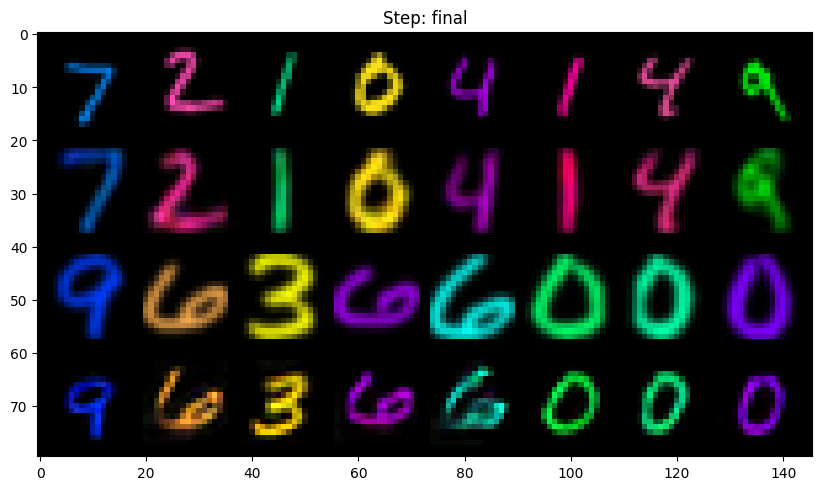

In [9]:
show_cyclegan_images('final')

<!-- ## Beyond GANs: Neural Optimal Transport  -->

<!-- The seminar materials are taken from the recent [**Neural Optimal Transport** paper](https://arxiv.org/pdf/2201.12220.pdf) repository [NOT_github](https://github.com/iamalexkorotin/NeuralOptimalTransport) by [Alex Korotin](https://scholar.google.ru/citations?user=1rIIvjAAAAAJ&hl=en)

**Storng OT**: <a href="https://colab.research.google.com/github/iamalexkorotin/NeuralOptimalTransport/blob/main/seminars/NOT_seminar_strong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> [![Open In Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=Open%20in%20Github&color=lightgrey)](https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/seminars/NOT_seminar_strong.ipynb)

**Strong OT, solutions**:
<a href="https://colab.research.google.com/github/iamalexkorotin/NeuralOptimalTransport/blob/main/seminars/NOT_seminar_strong_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> [![Open In Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=Open%20in%20Github&color=lightgrey)](https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/seminars/NOT_seminar_strong_solutions.ipynb)

**Weak OT**:
<a href="https://colab.research.google.com/github/iamalexkorotin/NeuralOptimalTransport/blob/main/seminars/NOT_seminar_weak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> [![Open In Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=Open%20in%20Github&color=lightgrey)](https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/seminars/NOT_seminar_weak.ipynb)

**Weak OT, solutions**:
<a href="https://colab.research.google.com/github/iamalexkorotin/NeuralOptimalTransport/blob/main/seminars/NOT_seminar_weak_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> [![Open In Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=Open%20in%20Github&color=lightgrey)](https://github.com/iamalexkorotin/NeuralOptimalTransport/blob/main/seminars/NOT_seminar_weak_solutions.ipynb) -->